# TP 1: LDA/QDA y optimización matemática de modelos
## Alumnos: 
### - Maximiliano Christener
### - Luiz Diaz Charris
### - Mariano Fagre
### - Juan Pablo Skobalski
### - Ronald Uthurralt

# Intro teórica

## Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

## Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

## LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

## Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

## Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

# Código provisto

Con el fin de no retrasar al alumno con cuestiones estructurales y/o secundarias al tema que se pretende tratar, se provee una base de código que **no es obligatoria de usar** pero se asume que resulta resulta beneficiosa.

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as LA
from scipy.linalg import cholesky, solve_triangular
from scipy.linalg.lapack import dtrtri

## Base code

In [2]:
class BaseBayesianClassifier:
  def __init__(self):
    pass

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    # Cuenta la frecuencia de cada categoría j en y para calcular pi sub j
    return np.log(a_priori)

  def _fit_params(self, X, y): #RU: vacío, creo que está para las clases hijas
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx): #RU: vacío, creo que está para las clases hijas
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # if it's needed, estimate a priori probabilities RU: si no cargo a_priori lo calcula, si no usa el valor cargado 
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?
    # No puede ir antes porque necesita que log_a_priori esté definida

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=int)

    for i in range(m_obs):
      y_hat[i] = self._predict_one(X[:,i].reshape(-1,1))

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i #RU:_predict_log_conditional depende del modelo 
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [3]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [LA.inv(np.cov(X[:,y.flatten()==idx], bias=True)) #RU esto da la inversa de la matriz de covarianza de cada categoria
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # por la dimensionalidad de y. label_encode devuelve y como matriz y no como vector. Para seleccionar las columnas de X con y==idex necesitamos un vector boolano
      
    # Q6: por que se usa bias=True en vez del default bias=False?
    # Porque en el cálculo de la matriz de covarianza se utiliza el estimador de MV (divide por n, no por n-1)
      
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?
    # Porque split_transpose transpone X e y, por lo que los casos individuales están en columnas. axis=1 hace que mean calcule el promedio de los casos para cada variable en X

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx] #RU: class_idx toma su valor de _predict_one en _predict_log_conditional(x, idx) for...
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(LA.det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x 
    #RU: 0.5*np.log(LA.det(inv_cov)) es lo mismo que -0.5 np.log(LA.det(cov))

In [4]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs) #RU: apila las matrices inv_covs (k, p, p) (apila en axis=0 por default)
        self.tensor_means = np.stack(self.means) #RU: tambien apila matrices (k, p, 1), porque self.means tiene dimensionalidad (p, 1)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means # np aplica broadcasting a x dimensionalidad (p, 1) y la dimensionalidad de unbiased_x es (k, p, 1)
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [5]:
class QDA_Chol1(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.L_invs = [
        LA.inv(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True))
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L_inv = self.L_invs[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = L_inv @ unbiased_x

    return np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()

In [6]:
class QDA_Chol2(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.Ls = [
        cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True)
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L = self.Ls[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = solve_triangular(L, unbiased_x, lower=True)

    return -np.log(L.diagonal().prod()) -0.5 * (y**2).sum()

In [7]:
class QDA_Chol3(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.L_invs = [
        dtrtri(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True), lower=1)[0]
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L_inv = self.L_invs[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = L_inv @ unbiased_x

    return np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()

## Datasets

Observar que se proveen **4 datasets diferentes**, el código de ejemplo usa uno solo pero eso no significa que ustedes se limiten al mismo. También pueden usar otros datasets de su elección.

In [8]:
from sklearn.datasets import load_iris, fetch_openml, load_wine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins_dataset():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

def get_wine_dataset():
    # get data
    data = load_wine()
    X_full = data.data
    y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
    return X_full, y_full

def get_letters_dataset():
    # get data
    letter = fetch_openml('letter', version=1, as_frame=False)
    return letter.data, letter.target.reshape(-1,1)

def label_encode(y_full):
    return LabelEncoder().fit_transform(y_full.flatten()).reshape(y_full.shape)

def split_transpose(X, y, test_size, random_state):
    # X_train, X_test, y_train, y_test but all transposed
    return [elem.T for elem in train_test_split(X, y, test_size=test_size, random_state=random_state)]

## Benchmarking

Nota: esta clase fue creada bastante rápido y no pretende ser una plataforma súper confiable sobre la que basarse, sino más bien una herramienta simple con la que poder medir varios runs y agregar la información.

En forma rápida, `warmup` es la cantidad de runs para warmup, `mem_runs` es la cantidad de runs en las que se mide el pico de uso de RAM y `n_runs` es la cantidad de runs en las que se miden tiempos.

La razón por la que se separan es que medir memoria hace ~2.5x más lento cada run, pero al mismo tiempo se estabiliza mucho más rápido.

**Importante:** tener en cuenta que los modelos que predicen en batch (usan `predict` directamente) deberían consumir, como mínimo, $n$ veces la memoria de los que predicen por observación.

In [9]:
import time
from tqdm.notebook import tqdm
from numpy.random import RandomState
import tracemalloc

RNG_SEED = 6553

class Benchmark:
    def __init__(self, X, y, n_runs=1000, warmup=100, mem_runs=100, test_sz=0.3, rng_seed=RNG_SEED, same_splits=True):
        self.X = X
        self.y = y
        self.n = n_runs
        self.warmup = warmup
        self.mem_runs = mem_runs
        self.test_sz = test_sz
        self.det = same_splits
        if self.det:
            self.rng_seed = rng_seed
        else:
            self.rng = RandomState(rng_seed)

        self.data = dict()

        print("Benching params:")
        print("Total runs:",self.warmup+self.mem_runs+self.n)
        print("Warmup runs:",self.warmup)
        print("Peak Memory usage runs:", self.mem_runs)
        print("Running time runs:", self.n)
        approx_test_sz = int(self.y.size * self.test_sz)
        print("Train size rows (approx):",self.y.size - approx_test_sz)
        print("Test size rows (approx):",approx_test_sz)
        print("Test size fraction:",self.test_sz)

    def bench(self, model_class, **kwargs):
        name = model_class.__name__
        time_data = np.empty((self.n, 3), dtype=float)  # train_time, test_time, accuracy
        mem_data = np.empty((self.mem_runs, 2), dtype=float)  # train_peak_mem, test_peak_mem
        rng = RandomState(self.rng_seed) if self.det else self.rng


        for i in range(self.warmup):
            # Instantiate model with error check for unsupported parameters
            model = model_class(**kwargs)

            # Generate current train-test split
            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )
            # Run training and prediction (timing or memory measurement not recorded)
            model.fit(X_train, y_train)
            model.predict(X_test)

        for i in tqdm(range(self.mem_runs), total=self.mem_runs, desc=f"{name} (MEM)"):

            model = model_class(**kwargs)

            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )

            tracemalloc.start()

            t1 = time.perf_counter()
            model.fit(X_train, y_train)
            t2 = time.perf_counter()

            _, train_peak = tracemalloc.get_traced_memory()
            tracemalloc.reset_peak()

            model.predict(X_test)
            t3 = time.perf_counter()
            _, test_peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            mem_data[i,] = (
                train_peak / (1024 * 1024),
                test_peak / (1024 * 1024)
            )

        for i in tqdm(range(self.n), total=self.n, desc=f"{name} (TIME)"):
            model = model_class(**kwargs)

            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )

            t1 = time.perf_counter()
            model.fit(X_train, y_train)
            t2 = time.perf_counter()
            preds = model.predict(X_test)
            t3 = time.perf_counter()

            time_data[i,] = (
                (t2 - t1) * 1000,
                (t3 - t2) * 1000,
                (y_test.flatten() == preds.flatten()).mean()
            )

        self.data[name] = (time_data, mem_data)

    def summary(self, baseline=None):
        aux = []
        for name, (time_data, mem_data) in self.data.items():
            result = {
                'model': name,
                'train_median_ms': np.median(time_data[:, 0]),
                'train_std_ms': time_data[:, 0].std(),
                'test_median_ms': np.median(time_data[:, 1]),
                'test_std_ms': time_data[:, 1].std(),
                'mean_accuracy': time_data[:, 2].mean(),
                'train_mem_median_mb': np.median(mem_data[:, 0]),
                'train_mem_std_mb': mem_data[:, 0].std(),
                'test_mem_median_mb': np.median(mem_data[:, 1]),
                'test_mem_std_mb': mem_data[:, 1].std()
            }
            aux.append(result)
        df = pd.DataFrame(aux).set_index('model')

        if baseline is not None and baseline in self.data:
            df['train_speedup'] = df.loc[baseline, 'train_median_ms'] / df['train_median_ms']
            df['test_speedup'] = df.loc[baseline, 'test_median_ms'] / df['test_median_ms']
            df['train_mem_reduction'] = df.loc[baseline, 'train_mem_median_mb'] / df['train_mem_median_mb']
            df['test_mem_reduction'] = df.loc[baseline, 'test_mem_median_mb'] / df['test_mem_median_mb']
        return df

## Ejemplo

In [10]:
# levantamos el dataset Wine, que tiene 13 features y 178 observaciones en total
X_full, y_full = get_wine_dataset()
X_full.shape, y_full.shape

((178, 13), (178, 1))

In [11]:
# encodeamos a número las clases
y_full_encoded = label_encode(y_full)

y_full[:5], y_full_encoded[:5]

(array([['class_0'],
        ['class_0'],
        ['class_0'],
        ['class_0'],
        ['class_0']], dtype='<U7'),
 array([[0],
        [0],
        [0],
        [0],
        [0]]))

In [12]:
# generamos el benchmark
# observar que son valores muy bajos de runs para que corra rápido ahora
b = Benchmark(
    X_full, y_full_encoded,
    n_runs = 100,
    warmup = 20,
    mem_runs = 20,
    test_sz = 0.3,
    same_splits = False
)

Benching params:
Total runs: 140
Warmup runs: 20
Peak Memory usage runs: 20
Running time runs: 100
Train size rows (approx): 125
Test size rows (approx): 53
Test size fraction: 0.3


In [13]:
# bencheamos un par
to_bench = [QDA_Chol3]

for model in to_bench:
    b.bench(model)

QDA_Chol3 (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

QDA_Chol3 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
# como es una clase, podemos seguir bencheando más después
b.bench(TensorizedQDA)

TensorizedQDA (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
# hacemos un summary
b.summary()

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb
model,,,,,,,,,
QDA_Chol3,0.24110,0.139053,1.06985,0.217206,0.982407,0.018486,0.000711,0.007744,0.000071
TensorizedQDA,0.25835,0.239207,0.81290,0.265217,0.982593,0.018463,0.000679,0.012108,0.000152


In [16]:
# son muchos datos! nos quedamos con un par nomás
summ = b.summary()

# como es un pandas DataFrame, subseteamos columnas fácil
summ[['train_median_ms', 'test_median_ms','mean_accuracy']]

,train_median_ms,test_median_ms,mean_accuracy
model,,,
QDA_Chol3,0.24110,1.06985,0.982407
TensorizedQDA,0.25835,0.81290,0.982593


In [17]:
# podemos setear un baseline para que fabrique columnas de comparación
summ = b.summary(baseline='QDA')

summ

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb
model,,,,,,,,,
QDA_Chol3,0.24110,0.139053,1.06985,0.217206,0.982407,0.018486,0.000711,0.007744,0.000071
TensorizedQDA,0.25835,0.239207,0.81290,0.265217,0.982593,0.018463,0.000679,0.012108,0.000152


In [18]:
summ[[
    'train_median_ms', 'test_median_ms','mean_accuracy',
]]

,train_median_ms,test_median_ms,mean_accuracy
model,,,
QDA_Chol3,0.24110,1.06985,0.982407
TensorizedQDA,0.25835,0.81290,0.982593


# Consigna QDA

**Notación**: en general notamos

* $k$ la cantidad de clases
* $n$ la cantidad de observaciones
* $p$ la cantidad de features/variables/predictores

**Sugerencia:** combinaciones adecuadas de `transpose`, `stack`, `reshape` y, ocasionalmente, `flatten` y `diagonal` suele ser más que suficiente. Se recomienda *fuertemente* explorar la dimensionalidad de cada elemento antes de implementar las clases.

## Tensorización

En esta sección nos vamos a ocupar de hacer que el modelo sea más rápido para generar predicciones, observando que incurre en un doble `for` dado que predice en forma individual un escalar para cada observación, para cada clase. Paralelizar ambos vía tensorización suena como una gran vía de mejora de tiempos.

### 1) Diferencias entre `QDA`y `TensorizedQDA`

1. ¿Sobre qué paraleliza `TensorizedQDA`? ¿Sobre las $k$ clases, las $n$ observaciones a predecir, o ambas?
2. Analizar los shapes de `tensor_inv_covs` y `tensor_means` y explicar paso a paso cómo es que `TensorizedQDA` llega a predecir lo mismo que `QDA`.

### 2) Optimización

Debido a la forma cuadrática de QDA, no se puede predecir para $n$ observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de $n \times n$ en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

3. Implementar el modelo `FasterQDA` (se recomienda heredarlo de `TensorizedQDA`) de manera de eliminar el ciclo for en el método predict.
4. Mostrar dónde aparece la mencionada matriz de $n \times n$, donde $n$ es la cantidad de observaciones a predecir.
5. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de $n \times n$ usando matrices de $n \times p$. También se puede usar, de forma equivalente,
$$
np.sum(A^T \odot B, axis=0).T
$$
queda a preferencia del alumno cuál usar.
6. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente en un nuevo modelo `EfficientQDA`.
7. Comparar la performance de las 4 variantes de QDA implementadas hasta ahora (no Cholesky) ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

## Cholesky

Hasta ahora todos los esfuerzos fueron enfocados en realizar una predicción más rápida. Los tiempos de entrenamiento (teóricos al menos) siguen siendo los mismos o hasta (minúsculamente) peores, dado que todas las mejoras siguen llamando al método `_fit_params` original de `QDA`.

La descomposición/factorización de [Cholesky](https://en.wikipedia.org/wiki/Cholesky_decomposition#Statement) permite factorizar una matriz definida positiva $A = LL^T$ donde $L$ es una matriz triangular inferior. En particular, si bien se asume que $p \ll n$, invertir la matriz de covarianzas $\Sigma$ para cada clase impone un cuello de botella que podría alivianarse. Teniendo en cuenta que las matrices de covarianza son simétricas y salvo degeneración, definidas positivas, Cholesky como mínimo debería permitir invertir la matriz más rápido.

*Nota: observar que calcular* $A^{-1}b$ *equivale a resolver el sistema* $Ax=b$.

### 3) Diferencias entre implementaciones de `QDA_Chol`

8. Si una matriz $A$ tiene fact. de Cholesky $A=LL^T$, expresar $A^{-1}$ en términos de $L$. ¿Cómo podría esto ser útil en la forma cuadrática de QDA?
9. Explicar las diferencias entre `QDA_Chol1`y `QDA` y cómo `QDA_Chol1` llega, paso a paso, hasta las predicciones.
10. ¿Cuáles son las diferencias entre `QDA_Chol1`, `QDA_Chol2` y `QDA_Chol3`?
11. Comparar la performance de las 7 variantes de QDA implementadas hasta ahora ¿Qué se observa?¿Hay alguna de las implementaciones de `QDA_Chol` que sea claramente mejor que las demás?¿Alguna que sea peor?

### 4) Optimización

12. Implementar el modelo `TensorizedChol` paralelizando sobre clases/observaciones según corresponda. Se recomienda heredarlo de alguna de las implementaciones de `QDA_Chol`, aunque la elección de cuál de ellas queda a cargo del alumno según lo observado en los benchmarks de puntos anteriores.
13. Implementar el modelo `EfficientChol` combinando los insights de `EfficientQDA` y `TensorizedChol`. Si se desea, se puede implementar `FasterChol` como ayuda, pero no se contempla para el punto.
14. Comparar la performance de las 9 variantes de QDA implementadas ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

## Importante:

Las métricas que se observan al realizar benchmarking son muy dependientes del código que se ejecuta, y por tanto de las versiones de las librerías utilizadas. Una forma de unificar esto es utilizando un gestor de versiones y paquetes como _uv_ o _Poetry_, otra es simplemente usando una misma VM como la que provee Colab.

**Cada equipo debe informar las versiones de Python, NumPy y SciPy con que fueron obtenidos los resultados. En caso de que sean múltiples, agregar todos los casos**. La siguiente celda provee una ayuda para hacerlo desde un notebook, aunque como es una secuencia de comandos también sirve para consola.

In [19]:
%%cmd
python --version
pip freeze | findstr "scipy numpy"

Microsoft Windows [Version 10.0.22631.4751]
(c) Microsoft Corporation. All rights reserved.

(ceia-amia-tp) c:\git\tp_amia>python --version
Python 3.12.11

(ceia-amia-tp) c:\git\tp_amia>pip freeze | findstr "scipy numpy"
numpy==2.2.6
scipy==1.16.1

(ceia-amia-tp) c:\git\tp_amia>

**Comentario:** yo utilicé los siguientes parámetros para mi run de prueba. Esto NO significa que ustedes tengan que usar los mismos, tampoco el mismo dataset. Se agregó al notebook simplemente porque fue una pregunta común en cohortes anteriores.

In [20]:
# dataset de letters
X_letter, y_letter = get_letters_dataset()

# encoding de labels
y_letter_encoded = label_encode(y_letter.reshape(-1,1))

# instanciacion del benchmark
b = Benchmark(
    X_letter, y_letter_encoded,
    same_splits=False,
    n_runs=100,
    warmup=20,
    mem_runs=30,
    test_sz=0.2
)

Benching params:
Total runs: 150
Warmup runs: 20
Peak Memory usage runs: 30
Running time runs: 100
Train size rows (approx): 16000
Test size rows (approx): 4000
Test size fraction: 0.2


------------------------------------------------------------------------------------------------------

In [21]:
%%cmd
python --version
pip freeze | findstr "scipy numpy"

Microsoft Windows [Version 10.0.22631.4751]
(c) Microsoft Corporation. All rights reserved.

(ceia-amia-tp) c:\git\tp_amia>python --version
Python 3.12.11

(ceia-amia-tp) c:\git\tp_amia>pip freeze | findstr "scipy numpy"
numpy==2.2.6
scipy==1.16.1

(ceia-amia-tp) c:\git\tp_amia>

---

### 1) Diferencias entre `QDA`y `TensorizedQDA`

1. ¿Sobre qué paraleliza `TensorizedQDA`? ¿Sobre las $k$ clases, las $n$ observaciones a predecir, o ambas?

TensorizedQDA paraleliza sobre k (clases) y no paraleliza sobre n (observaciones). En BayesClassifier `_predict_one(self, x)` tiene un loop que analiza todas las clases para una observación `log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i in enumerate(self.log_a_priori) ]`
   En BayesClassifier `predict(self, X)` tiene otro loop que corre `_predict(self, X)` para cada una de las observaciones `for i in range(m_obs): y_hat[i] = self._predict_one(X[:,i].reshape(-1,1))`. QDA recurre a estos dos bucles para calcular la predicción, usando `_predict_log_conditional(self, x, class_idx)` para cada combinación de `x` y de `class_idx`.
   TensorizedQDA calcula `_predict_log_conditionals(self,x):` en forma tensorizada y no recurre al bucle que calcula la predicción para cada `class_idx`. Luego corre el bucle `for i in range(m_obs): y_hat[i] = self._predict_one(X[:,i].reshape(-1,1))` de `predict(self, X)` en BayesClassifier.



   

2. Analizar los shapes de `tensor_inv_covs` y `tensor_means` y explicar paso a paso cómo es que `TensorizedQDA` llega a predecir lo mismo que `QDA`.

```Python
     self.tensor_inv_cov = np.stack(self.inv_covs) 
        # np.stack(self.inv_covs) apila las k matrices (p x p) de self.inv_covs en un tensor (k x p x p) (apila k veces en axis=0 por default)
        self.tensor_means = np.stack(self.means)
        # np.stack(self.means) apila las k matrices (p x 1) de self.means en un tensor (k x p x 1)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        # np aplica broadcasting a x dimensionalidad (p x 1) y lo expande a (k x p x 1) para que coincida con 
        # la dimensionalidad de tensor_means (k x p x 1)
        # la resta de x (k x p x 1) menos tensor_means (k x p x 1) mantiene la dimensionalidad para unbiased_x (k x p x 1)
        
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x
        # la trasposición(0,2,1) de unbiased_x da un tensor con dimensionalidad (k x 1 x p)
        # self.tensor_inv_covs tenía dimensionalidad (k x p x p) y unbiased_x (k x p x 1)
        # Si el primer eje concide en dimensionalidad (r), @ de dos tensores multiplica sobre los dos últimos ejes (m x n) y (n x q)
        # para cada r y los apila en un tensor con dimensionalidad (r x m x q)
        # en nuestro caso unbiased_x.transpose(0,2,1) (k x 1 x p) @ self.tensor_inv_cov (k x p x p) resulta en un tensor (k x 1 x p)
        # y este @ unbiased_x (k x p x 1) resulta en un tensor (k x 1 x 1)
        # pero esto es lo mismo que hacer para cada k (x-self.means).T @ self.inv_cons @ (x-self.means), tal como se hace en QDA con un bucle
        
        return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()
        # flatten() transforma a inner_prod (k x 1 x 1) en un vector (k)

---
### 2) Optimizacion

3. Implementar el modelo `FasterQDA` (se recomienda heredarlo de `TensorizedQDA`) de manera de eliminar el ciclo for en el método predict.

In [22]:
class FasterQDA(TensorizedQDA):
    """
    Vectorizamos la prediccion sobre TODAS las observaciones a la vez. Esta versión arma una matriz (k, n, n) por clase y despues soquedamos unicamente con la diagonal. 
    """

    def predict(self, X):
        """
        X: array de shape (p, n)  -> p features, n observaciones
        return: array de shape (n,) con la clase predicha por observación
        """

        # 1) Centramos todas las observaciones X con el vector de medias de CADA clase
        #    - self.tensor_means tiene shape (k, p, 1)
        #    - X tiene shape (p, n)
        #    Con broadcasting, obtengo unbiased de shape (k, p, n): para cada clase k, resto su media a todas las columnas de X.
        unbiased = X[None, :, :] - self.tensor_means  # (k, p, n)

        # 2) Aplicamos la forma cuadratica (x - μ)^T Σ^{-1} (x - μ) pero en batches de observaciones:
        #    Primero transponemos unbiased para tener (k, n, p) a la izquierda, y dejamos (k, p, p) y (k, p, n) en el medio y derecha.
        #    El producto da M con shape (k, n, n): ahi aparecen TODAS las interacciones entre observaciones.
        m = np.transpose(unbiased, (0, 2, 1)) @ self.tensor_inv_cov @ unbiased  # (k, n, n)

        # 3) Para la forma cuadratica solo necesitamps la diagonal por clase/obs:
        #    diag(M) tiene shape (k, n). Nos ahorramos usar toda la matriz M despues.
        inner = np.diagonal(m, axis1=1, axis2=2)  # (k, n)

        # 4) terminamos log-determinante para cada clase:
        #    uso slogdet por estabilidad numérica.
        #    Ojo: tengo Σ^{-1} ya precalculada; log|Σ^{-1}| = -log|Σ|.
        #    slogdet sobre (k, p, p) me devuelve arrays de largo k.
        sign, logdet_inv = LA.slogdet(self.tensor_inv_cov)  # (k,)

        # 5) armamos los log-condicionales por clase y por observacion:
        #    broadcasting para que el logdet_inv (k,) se expanda a (k, n).
        log_conditionals = 0.5 * logdet_inv[:, None] - 0.5 * inner  # (k, n)

        # 6) sumamos log-priors por clase y elejimos la clase con mayor puntaje para cada obs
        scores = self.log_a_priori[:, None] + log_conditionals  # (k, n)
        yhat = np.argmax(scores, axis=0)  # (n,)
        return yhat

    # Dejo un helper opcional si quiero reusar la parte de log-condicionales en otros métodos
    def _predict_log_conditionals_batch(self, X):
        """
        Devolvemos la matriz (k, n) con los log-condicionales para todas las observaciones.
        Solo lo usamos si queremos calcular proba/scores sin repetir codigo.
        """
        unbiased = X[None, :, :] - self.tensor_means # (k, p, n)
        m = np.transpose(unbiased, (0, 2, 1)) @ self.tensor_inv_cov @ unbiased # (k, n, n)
        inner = np.diagonal(m, axis1=1, axis2=2) # (k, n)
        _, logdet_inv = LA.slogdet(self.tensor_inv_cov) # (k,)
        return 0.5 * logdet_inv[:, None] - 0.5 * inner # (k, n)


**4. Mostrar dónde aparece la mencionada matriz de $n \times n$, donde $n$ es la cantidad de observaciones a predecir.**

La matriz de tamaño $n \times n$ aparece en el paso de vectorizacion de la prediccion, cuando calculamos en bloque la forma cuadratica para todas las observaciones y todas las clases. En el metodo `predict` de `FasterQDA` se construye:

```python
m = np.transpose(unbiased, (0, 2, 1)) @ self.tensor_inv_cov @ unbiased  # (k, n, n)
```

**5. Demostrar que**
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de $n \times n$ usando matrices de $n \times p$. También se puede usar, de forma equivalente,
$$
np.sum(A^T \odot B, axis=0).T
$$
**queda a preferencia del alumno cuál usar.**

## Desarrollo
Para la demostración, se tomará cada lado de la igualdad para llevarla a una expresión tal que la equivalencia sea evidente.

### Lado izquierdo
Téngase la diagonal de una matriz resultante de un producto matricial, esto es,
$$
diag(A \cdot B) = diag(C) = D
$$ 

Por definición de diagonal principal, $C$ debe ser cuadrada. De allí, podemos decir que $C$ es de dimensión $n\times n$. Además, para que el producto $A\cdot B$ sea conforme, entonces $A$ es de $n\times p$ y $B$ es de $p\times n$. Por lo cual, sabiendo las dimensiones de la matriz que necesitamos para calcular su diagonal y cumpliendo con la conformidad del producto matricial, con seguridad decimos que $C_{n\times n} = A_{n\times p} \cdot B_{p\times n}$
Ahora, $C_{n\times n} = [c_{ij}]$, donde $i,j \in \{1,\dots, n\}$. Por definición de producto matricial, cada elemento está definido por
$$
c_{ij} = \sum_{k=1}^p a_{ik} b_{kj}
$$

Si buscamos $diag(C)$, entonces solo estamos interesados en aquellos elementos de $C$ en donde $i=j$. Si definimos $D=diag(C)$, sabemos que $D$ es un vector en $R^n$, por lo que $D=[d_i]\quad \forall i \in \{1,\dots,n\}$. Con esto en mente, cada elemento de $D$ es
\begin{equation}
d_i = c_{ii} = \sum_{k=1}^p a_{ik} b_{ki}
\end{equation}

### Lado derecho

A partir del razonamiento anterior, sabemos que $A_{n\times p} = [a_{ij}]$ y $B_{p\times n} = [b_{ij}]$. Si transponemos $B$, entonces por definición $B^T_{n\times p} = [b'_{ij}] = [b_{ji}]$.
Definamos el [producto de Hadamard](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) como la multiplicación elemento a elemento entre dos matrices de iguales dimensiones, en este caso $n\times p$. Así, $H_{n\times p}=A\odot B^T$, donde $H_{n\times p}=[h_{ij}]$ tal que
$$
h_{ij​} = a_{ij​}\cdot b_{ji}
$$

La expresión de la consigna exigía que $\sum_{cols} A \odot B^T$. En otras palabras, queremos sumar todos los $p$ elementos en cada i-ésima fila. Con ello obtenemos un vector $V \in R^n$ que se compone de

\begin{equation}
\tag{2}
v_i = \sum^p_{j=1} h_{ij} = \sum^p_{k=1} a_{ik}b'_{ik} = \sum^p_{k=1} a_{ik}b_{ki}
\end{equation}

### Conclusión

Del lado izquierdo, tenemos $D_{i} = [d_i] = diag(A\cdot B)$; mientras que del derecho, $V_i = [v_i] = \sum_{cols}  A\odot B^T$ (donde $i \in \{1,\dots,n\}$). Entonces, por la ecuación 1 y 2 se sabe que los elementos de $D$ y de $V$ son equivalentes. En términos simbólicos, cada elemento resultante de ambos lados de la expresión está dado por
$$
v_i = d_i = \sum^p_{k=1} a_{ik}b_{ki} 
$$
Con esto, $diag(A \cdot B) = \sum_{cols} A \odot B^T$ porque cada elemento del vector resultante posee los mismos elementos, demostrando lo requerido en la consigna.


In [23]:
import numpy as np
from numpy import random as rnd

In [24]:
class Benchmarking:
    """
    Una clase que usamos para realizar el benchmarking.

    Al inicializar, genera dos matrices A y B de tamaño nxp y pxn,
    respectivamente. Luego, puedo realizar el cálculo de forma ineficiente con
    el método `.inefficient()`, o eficientemente con `.efficient()`

    Argumentos:
    - n: Entero positivo para las filas de A y las columnas de B.
    - p: Entero positivo para las columnas de A y las filas de B.
    - random_seed (opcional): Si le otorgo un valor, genero A y B con una
    semilla predefinida.
    """
    def __init__(self, n, p, random_seed=None):
        if random_seed is not None:
            rnd.seed(random_seed)
        # Genero las matrices A y B con números aleatorios
        self.A = rnd.rand(n,p)
        self.B = rnd.rand(p,n)

    def inefficient(self):
        return np.diag(self.A @ self.B) # Lado izquierdo de la igualdad

    def efficient(self):
        return np.sum(self.A * self.B.T, axis=1) # Lado derecho de la igualdad

Para inicializar, utilizo números grandes a modo que la diferencia en eficiencia sea evidente: $n = 10.000$ y $p=10$. 

**Opcional:** Fijamos la semilla en 123 para asegurar reproducibilidad, pero podría omitirse o cambiarse en caso de querer experimentar con otros números.

# Inicializo la clase
calc = Benchmarking(n=10000, p=10, random_seed=123)

Hago los cálculos, primero de forma ineficiente y luego de la manera eficiente.

%%timeit
calc.inefficient()

%%timeit
calc.efficient()

En promedio, el método ineficiente tardó ~1 segundo por loop, mientras que el eficiente le tomó tan solo 650 microsegundos computar cada iteración.

**6. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente en un nuevo modelo `EfficientQDA`.**

In [25]:
class EfficientQDA(FasterQDA):
    """
    Vectorizamos la prediccion sobre TODAS las observaciones a la vez. 
    Esta versión arma una matriz (k, n, n) por clase y despues soquedamos 
    unicamente con la diagonal. 
    """

    def predict(self, X):
        """
        X: array de shape (p, n)  -> p features, n observaciones
        return: array de shape (n,) con la clase predicha por observación
        """

        # 1) Centramos todas las observaciones X con el vector de medias de CADA clase
        #    - self.tensor_means tiene shape (k, p, 1)
        #    - X tiene shape (p, n)
        #    Con broadcasting, obtengo unbiased de shape (k, p, n): para cada clase k, 
        #    resto su media a todas las columnas de X.
        unbiased = X[None, :, :] - self.tensor_means  # (k, p, n)

        # 2) Aplicamos la forma cuadratica (x - μ)^T Σ^{-1} (x - μ):
        #    Para EfficientQDA() evitamos crear la matriz intermedia M de (k, n, n) que 
        #    puede ser muy grande si el número de observaciones n es grande.
        #    En su lugar nos quedamos con el producto Σ^{-1} (x - μ), representado 
        #    en la matriz A que se  muestra a continuación: 
        A = self.tensor_inv_cov @ unbiased  # (k, p, n)

        # 3) Para la forma cuadratica solo necesitamps la diagonal por clase/observación:
        #    Ahora se necesita calcular la forma cuadratica (x - μ)^T Σ^{-1} (x - μ) = U^T A
        #    y obtener su diagonal aplicando la propiedad diag(A . B) = np.sum(A @ B.T, axis = 1)
        #    que en este caso sería diag(U . A) = np.sum(U^T @ A, axis = 1)
        #    Donde: U^T = (x - μ)^T con forma (k, n, p)
        inner = np.sum(np.transpose(unbiased, (0, 2, 1)) @ A, axis=1)  # (k, n)

        # 4) terminamos log-determinante para cada clase:
        #    uso slogdet por estabilidad numérica.
        #    Ojo: tengo Σ^{-1} ya precalculada; log|Σ^{-1}| = -log|Σ|.
        #    slogdet sobre (k, p, p) me devuelve arrays de largo k.
        _, logdet_inv = LA.slogdet(self.tensor_inv_cov)  # (k,)

        # 5) armamos los log-condicionales por clase y por observacion:
        #    broadcasting para que el logdet_inv (k,) se expanda a (k, n).
        log_conditionals = 0.5 * logdet_inv[:, None] - 0.5 * inner  # (k, n)

        # 6) sumamos log-priors por clase y elejimos la clase con mayor puntaje para cada obs
        scores = self.log_a_priori[:, None] + log_conditionals  # (k, n)
        yhat = np.argmax(scores, axis=0)  # (n,)
        return yhat

    # Dejo un helper opcional si quiero reusar la parte de log-condicionales en otros métodos
    def _predict_log_conditionals_batch(self, X):
        """
        Devolvemos la matriz (k, n) con los log-condicionales para todas las observaciones.
        Solo lo usamos si queremos calcular proba/scores sin repetir codigo.
        """
        unbiased = X[None, :, :] - self.tensor_means # (k, p, n)
        A = self.tensor_inv_cov @ unbiased 
        inner = np.sum(np.transpose(unbiased, (0, 2, 1)) @ A, axis=1)
        _, logdet_inv = LA.slogdet(self.tensor_inv_cov) # (k,)
        return 0.5 * logdet_inv[:, None] - 0.5 * inner # (k, n)

7. Comparar la performance de las 4 variantes de QDA implementadas hasta ahora (no Cholesky) ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

### 4 Variantes de QDA comparadas 

- **`QDA`**: versión base; calcula e inserta los términos de cada clase con bucles más explícitos.
- **`TensorizedQDA`**: reduce bucles y vectoriza sobre las observaciones.
- **`FasterQDA`**: incrementa la vectorización y el uso de arrays intermedios.
- **`EfficientQDA`**: la más vectorizada; concentra el cálculo en pocas operaciones grandes.

### ¿Qué cambia entre variantes?

Todas implementan la misma regla de decisión QDA; lo que varía es **cómo** se computan, por clase \(k\), los términos: $(x-\mu_k)^{\top}\,\Sigma_k^{-1}\,(x-\mu_k)$ y $\log |(\Sigma_k)|$

haciendo mas precálculo por clase (por ejemplo $\Sigma_k^{-1}$ y $(\log|(\Sigma_k)|)$ y más vectorizaci+on para evitar bucles innecesarios. 

### Qué se observó

- **Exactitud**: prácticamente igual en las cuatro (si aparece alguna diferencia, es de redondeo numérico).
- **Tiempo de cómputo (de más lenta a más rápida):**  
  `QDA` < `TensorizedQDA` < `FasterQDA` < `EfficientQDA`
  
 A medida que se precomputan términos por clase y se reemplazan bucles por operaciones vectorizadas disminuye el trabajo repetido y mejora el tiempo.
- **Memoria**: las variantes más vectorizadas (en especial `EfficientQDA`) pueden usar más RAM por los intermedios; `TensorizedQDA`/`FasterQDA` suelen ofrecer un buen balance tiempo/RAM en tamaños medianos.

### Se condice con lo esperado?
Sí. En QDA el costo típico es:

 **Entrenamiento:** $O(K\,p^3)$ (una inversión/factorización por clase).
 
 **Predicción:** $O(n\,K\,p^2)$. Precomputar lo que no depende de $x$ y 
 
Precomputar lo que **no depende de \(x\)** y **vectorizar** (primero en \(n\), y cuando es posible también en \(K\)) debería acelerar, y eso es lo que se observó.


---

### 3) Diferencias entre implementaciones de QDA_Chol 

8. Si una matriz $A$ tiene fact. de Cholesky $A=LL^T$, expresar $A^{-1}$ en términos de $L$. ¿Cómo podría esto ser útil en la forma cuadrática de QDA?

Si una matriz simetrica definida positiva $A$ tiene factorizacion de Cholesky $A = L L^\top$ entonces su inversa se puede escribir como $A^{-1} = (L L^\top)^{-1} = (L^\top)^{-1} L^{-1}$

En otras palabras, basta con invertir la matriz triangular inferior $L$ (y su traspuesta) en lugar de invertir $A$ directamente.

En el contexto de QDA, la forma cuadrática que aparece es $(x - \mu)^\top \, \Sigma^{-1} \, (x - \mu)$

Si calculamos la descomposicion de Cholesky $\Sigma = L L^\top$, podemos reescribir:

$(x - \mu)^\top \Sigma^{-1} (x - \mu) = (x - \mu)^\top (L^\top)^{-1} L^{-1} (x - \mu)$

Definiendo $z = L^{-1} (x - \mu)$, esto se convierte en $z^\top z = \| z \|^2$

Esto es util porque evita calcular la inversa completa de $\Sigma$ (que es muy caro para calcular). En cambio, solo necesitamos resolver sistemas triangulares con $L$, lo cual es mas eficiente y estable.



9. Explicar las diferencias entre `QDA_Chol1`y `QDA` y cómo `QDA_Chol1` llega, paso a paso, hasta las predicciones.

QDA_Chol1 tiene la misma estructura que QDA pero recurre a la factorización de Cholesky para resolver 
$\frac{1}{2}\log |\Sigma^{-1}| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$
en forma más eficiente, de acuerdo con la factorización planteada en el punto anterior.

Para ello, en lugar de calcular las matrices inversas de covarianza en `def _fit_params(self, X, y):` con

`self.inv_covs = [LA.inv(np.cov(X[:,y.flatten()==idx], bias=True)) for idx in range(len(self.log_a_priori))]`

QDA_Chol1 calcula las matrices inversas de Cholesky con:  

`self.L_invs = [LA.inv(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True)) for idx in range(len(self.log_a_priori))`

Separando en dos partes los cambios en `def _predict_log_conditional(self, x, class_idx):`, tenemos en primer lugar que el cálculo del determinante $$
\frac{1}{2}\log |\Sigma^{-1}|$$ cambia de `np.log(LA.det(inv_cov))` a `np.log(L_inv.diagonal().prod())`, donde `L_inv` es la inversa de la matriz de Cholesky para cada categoría. En segundo lugar, el producto $$- \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j)
$$ pasa de ser `-0.5 * unbiased_x.T @ inv_cov @ unbiased_x`a ser `-0.5 * (y**2).sum()` con `y = L_inv @ unbiased_x`. Las operaciones en QDA y QDA_Col1 son algebráicamente equivalentes pero computacionalmente diferentes (QDA_Chol1 es más barata).

In [26]:
class QDA_Chol1(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.L_invs = [
        LA.inv(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True))
        for idx in range(len(self.log_a_priori))
    ]
    # Este paso estima la matriz de covarianza sigma para cada categoría idx, 
    # calcula la matriz de Cholesky correspondiente y calcula su inversa L^(-1)
    # y las acumula en L_invs.
    # lower=True devuelve la matriz triangular inferior
    # bias=True calcula la covarianza por máxima verosimilitud (divide por n en lugar de n-1)
 
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Este paso calcula means de la misma forma que en QDA
    
  def _predict_log_conditional(self, x, class_idx):
    L_inv = self.L_invs[class_idx]
    # L_inv toma la inversa de la matriz de Cholesky de una clase class_idx
    unbiased_x =  x - self.means[class_idx]
    # unbiased_x calcula (x-mu_j)

    y = L_inv @ unbiased_x
    # calcula L(-1) @ (x-mu) en la factorizacion de Cholesky de 
    # (x-mu).T @ sigma^(-1) @ (x-mu) = (x-mu).T @ (L.T)^(-1) @ L^(-1) @ (x-mu), 
    # recordando que (L^(-1)).T = (L.T)^(-1) si L es invertible

    return np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()
    # la primera parte de la resta calcula el log del determinante sabiendo que
    # el determinante de una matriz triangular es el producto de los valores de su diagonal
    # El det(sigma^(-1)) = det(L^(-1))^2, por lo que 0.5 * log(det(sigma^(-1))) = log(det(L^(-1))) = np.log(L_inv.diagonal().prod())
    # por lo que esté término es equivalente para QDA y QDA_Chol1
    # la segunda parte calcula 0.5 * norma de y, sabiendo por los desarrollos en el punto 8 que
    # 0.5 * (y**2) = 0.5 * (x-mu).T @ sigma^(-1) @ (x-mu), que es la operación que realiza QDA
    # tomado ambos términos de la resta, concluimos que las operaciones de QDA y QDA_Chol1 son algebráicamnte equivalentes

**10. ¿Cuáles son las diferencias entre `QDA_Chol1`, `QDA_Chol2` y `QDA_Chol3`?**

Las clases `QDA_Chol*` implementan, como su nombre lo indica, un algoritmo para aplicar Análisis Discriminante Cuadrático (QDA). Su diferencia está en cómo cada una realiza esta tarea. Todas se basan en la descomposición de Cholesky de la matriz de covarianianza ($\sigma$), que consiste en encontrar una matriz triangular inferior única $L$ tal que $\Sigma = L\cdot L^T$.

### QDA_Chol1
Esta es la implementación más *naive* de todas. Su punto a favor es que resulta fácil de escribir y entender. En contra, su ineficiencia computacional.

#### _fit_params

Comenzamos con el ajuste. Tiene dos atributos

- **Inversa:** Primero, se calcula la matriz de covarianza $\Sigma_k$​ para los datos de la clase actual, para luego aplicarle la descomposición de Cholesky sobre $\Sigma_k$ tal que $\Sigma_k = L_k L_k^T$. A esto, simplemente se le aplica su inversa (lo que computacionalmente suele ser relativamente demandante).

- **Vector de medias** El código itera sobre cada clase. Para cada una de ellas, selecciona de la matriz de datos $X$ solo las columnas que corresponden a esa clase. A esto, le toma la media (`axis=1` porque lo hace a través de las columnas).

#### _predict_log_conditional

A partir de `_fit_params`, obtiene vector de medias $\mu_k$ y la inversa de Cholesky $L_k^{-1}$ para calcular $y=L_k^{-1}\cdot (x-\mu_k)$. El último paso es aplicar la fórmula para la log probabilidad Normal multivariante.

### QDA_Chol2

Acá nos evitamos directamente el cálculo de la inversa y resolvemos el sistema lineal directamente usando `solve_triangular`.

#### _fit_params

Comenzamos con el ajuste. Tiene dos atributos:

- **Inversa:** Calcula la matriz de covarianza $\Sigma_k$​ para la clase actual para luego aplicar Cholesky sobre $\Sigma_k$ para obtener la matriz triangular inferior $L_k$.

- **Vector de medias** Igual a QDA_Chol1.

#### _predict_log_conditional

A partir de que la ecuación $y=L_k^ {−1}​(x−\mu_k​)$ es matemáticamente idéntica a resolver el sistema de ecuaciones lineales $L_k​y=(x−\mu_k​)$ para la incógnita $y$, se resuelve el sistema con la función solve_triangular para luego calcular la log-probabilidad, con la diferencia de que ahora se toma el logaritmo del producto de la diagonal de la matriz L, resultando algo más directo que QDA_Chol1. Al evitar el cálculo de la inversa, esta implementación resulta la **más eficiente computacionalmente**.

### QDA_Chol3

Este es un punto intermedio, que no evita calcular la inversa, pero lo hace de un modo ligeramente más eficiente que QDA_Chol1.

#### _fit_params

Comenzamos con el ajuste. Tiene dos atributos:

- **Inversa:** Calcula la matriz de covarianza $\Sigma_k$​ para la clase actual
para luego aplicar Cholesky sobre $\Sigma_k$ para obtener la matriz triangular
inferior $L_k$. Aquí, en lugar de usar la función genérica LA.inv(), utiliza
dtrtri. Esta es una función de bajo nivel proveniente de la biblioteca LAPACK.
Significa "double precision triangular inverse", y está optimizada para invertir
matrices triangulares.

- **Vector de medias** Igual a QDA_Chol1.

#### _predict_log_conditional

Idéntico a QDA_Chol1, simplemente porque ambos métodos trabajan con la inversa.

**11. Comparar la performance de las 7 variantes de QDA implementadas hasta ahora ¿Qué se observa?¿Hay alguna de las implementaciones de `QDA_Chol` que sea claramente mejor que las demás?¿Alguna que sea peor?**

In [27]:
# Se realiza el benchmark con el dataset de wines
X_full, y_full = get_wine_dataset()
X_full.shape, y_full.shape


# encodeamos a número las clases
y_full_encoded = label_encode(y_full)

y_full[:5], y_full_encoded[:5]


# generamos el benchmark
# observar que son valores muy bajos de runs para que corra rápido ahora
b = Benchmark(
    X_full, y_full_encoded,
    n_runs = 100,
    warmup = 20,
    mem_runs = 20,
    test_sz = 0.3,
    same_splits = False
)

Benching params:
Total runs: 140
Warmup runs: 20
Peak Memory usage runs: 20
Running time runs: 100
Train size rows (approx): 125
Test size rows (approx): 53
Test size fraction: 0.3


In [28]:
# Se cargan en el benchmark las 7 clases de QDA

to_bench = [QDA]

for model in to_bench:
    b.bench(model)

b.bench(TensorizedQDA)

b.bench(QDA_Chol1)

b.bench(QDA_Chol2)

b.bench(QDA_Chol3)

b.bench(FasterQDA)

b.bench(EfficientQDA)


QDA (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedQDA (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol1 (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

QDA_Chol1 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol2 (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

QDA_Chol2 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol3 (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

QDA_Chol3 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

FasterQDA (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

FasterQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientQDA (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

EfficientQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
b.summary()

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb
model,,,,,,,,,
QDA,0.24880,0.168989,1.78570,0.780514,0.982407,0.018463,0.000716,0.007682,0.000925
TensorizedQDA,0.23280,0.189925,0.71635,0.408433,0.982593,0.018463,0.000653,0.012108,0.000000
QDA_Chol1,0.26980,0.183868,1.03390,0.375434,0.985741,0.018036,0.000902,0.007889,0.000181
QDA_Chol2,0.23830,0.167551,2.65125,1.800330,0.983333,0.017971,0.000707,0.007953,0.000256
QDA_Chol3,0.22595,0.344883,1.12385,1.421442,0.986111,0.017799,0.000881,0.007607,0.000120
FasterQDA,0.19850,0.156090,0.05155,0.088217,0.982222,0.017776,0.000648,0.109161,0.000000
EfficientQDA,0.20130,2.541304,0.05805,0.128310,0.891296,0.017628,0.000798,0.110809,0.000000


In [30]:
summ = b.summary()

summ[['train_median_ms', 'test_median_ms','mean_accuracy']]

,train_median_ms,test_median_ms,mean_accuracy
model,,,
QDA,0.24880,1.78570,0.982407
TensorizedQDA,0.23280,0.71635,0.982593
QDA_Chol1,0.26980,1.03390,0.985741
QDA_Chol2,0.23830,2.65125,0.983333
QDA_Chol3,0.22595,1.12385,0.986111
FasterQDA,0.19850,0.05155,0.982222
EfficientQDA,0.20130,0.05805,0.891296


In [31]:
summ = b.summary(baseline='QDA')

summ[[
    'train_median_ms', 'test_median_ms','mean_accuracy',
    'train_speedup', 'test_speedup',
    'train_mem_reduction', 'test_mem_reduction',
]]

,train_median_ms,test_median_ms,mean_accuracy,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,
QDA,0.24880,1.78570,0.982407,1.000000,1.000000,1.000000,1.000000
TensorizedQDA,0.23280,0.71635,0.982593,1.068729,2.492776,1.000000,0.634452
QDA_Chol1,0.26980,1.03390,0.985741,0.922165,1.727150,1.023689,0.973767
QDA_Chol2,0.23830,2.65125,0.983333,1.044062,0.673531,1.027383,0.965943
QDA_Chol3,0.22595,1.12385,0.986111,1.101129,1.588913,1.037291,1.009905
FasterQDA,0.19850,0.05155,0.982222,1.253400,34.640153,1.038627,0.070371
EfficientQDA,0.20130,0.05805,0.891296,1.235966,30.761414,1.047392,0.069325


Mediciones realizadas para la comparación: 

<img src="./summary_Baseline_QDA_Punto_11.png" alt="Mediciones de prueba con QDA como Baseline" width="1000" height="500">


Teniendo en cuenta estas mediciones, se observa que `QDA_Chol2` entrena más rápido que la mayoría de modelos, con ligeras cercanías con `QDA_Chol3`, `QDA_Chol1` y `QDA`. 

El modelo con mejor exactitud es `QDA_Chol2`. El modelo con peor desempeño en cuanto a la exactitud media es `EfficientQDA`. Sin embargo, este modelo junto con `FasterQDA` son sobradamente superiores en el tiempo de predicción. 

En cuanto al *speedup* en entrenamiento, los modelos `FasterQDA`, `EfficientQDA` y `QDA_Chol1` tienen un desempeño  ligeranente menor que los demás modelos cuando se comparan con `QDA`; en este aspecto `QDA_Chol2` es superior a los demás modelos. Pero, Cando se trata de predecir `FasterQDA` y `EfficientQDA` son los más veloces.

En cuanto a la reducción de memoria en entrenamiento, comparados contra `QDA`, `TensorizedQDA` tiene el mismo uso de memoria, y ningún modelo es muy superior. Por otro lado, en cuanto a la reducción de momoria en entrenamiento, resaltan sobremanera los modelos `FasterQDA` y `EfficientQDA`. 

Para responder a las preguntas: *¿Hay alguna de las implementaciones de `QDA_Chol` que sea claramente mejor que las demás? ¿Alguna que sea peor?* Se corrió una comparación tomando como *baseline* a `QDA_Chol1`: 

<img src="./summary_Baseline_QDAChol1_Punto_11.png" alt="Mediciones de prueba con QDA como Baseline" width="1000" height="500">

In [32]:
# Se realiza auna comparación de los resultados tomando como baseline a QDA_Chol1

summ = b.summary(baseline='QDA_Chol1')

summ[[
    'train_median_ms', 'test_median_ms','mean_accuracy',
    'train_speedup', 'test_speedup',
    'train_mem_reduction', 'test_mem_reduction',
]]

,train_median_ms,test_median_ms,mean_accuracy,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,
QDA,0.24880,1.78570,0.982407,1.084405,0.578989,0.976860,1.026940
TensorizedQDA,0.23280,0.71635,0.982593,1.158935,1.443289,0.976860,0.651544
QDA_Chol1,0.26980,1.03390,0.985741,1.000000,1.000000,1.000000,1.000000
QDA_Chol2,0.23830,2.65125,0.983333,1.132186,0.389967,1.003609,0.991965
QDA_Chol3,0.22595,1.12385,0.986111,1.194069,0.919963,1.013288,1.037111
FasterQDA,0.19850,0.05155,0.982222,1.359194,20.056255,1.014592,0.072267
EfficientQDA,0.20130,0.05805,0.891296,1.340288,17.810509,1.023155,0.071193


Entre las variantes de `QDA_Chol`, se realizan los siguientes análisis: 


`QDA_Chol3`Presenta un mejor desempeño global, con una mayor precisión que el baseline (0.9856 vs 0.9822). Es más rápido en entrenamiento (1.43) y en test (1.20), con memoria muy similar al baseline (≈1.0). Así, `QDA_Chol3` supera al baseline en todo: más preciso y más veloz. Por lo tanto, se podría decir que es la mejor implementación de las variantes QDA_Chol.

`QDA_Chol2` Presenta un pero desempeño, aunque tiene la mayor precisión (0.9867), su tiempo de test es más lento que QDA_Chol1 (11.44 ms vs 3.99 ms). Su speedup de test es < 0.35, es decir, rinde solo el 35 % de la velocidad del baseline. Este modelo es poco eficiente; Aunque presenta una muy buena exactitud presenta una disminución drástica de velocidad frente al baseline.

---

### 4) Optimización

12. Implementar el modelo TensorizedChol paralelizando sobre clases/observaciones según corresponda. Se recomienda heredarlo de alguna de las implementaciones de QDA_Chol, aunque la elección de cuál de ellas queda a cargo del alumno según lo observado en los benchmarks de puntos anteriores.

In [33]:
import numpy as np
from scipy.linalg import cholesky, solve_triangular

class TensorizedChol(QDA_Chol3):
    """
    QDA con Cholesky y vectorización (full-batch).
    - Procesa clases × muestras en una sola pasada.
    - Usa solve_triangular para L^{-1}.
    """
    def __init__(self, reg=1e-6, priors=None):
        super().__init__()
        self.reg = float(reg)
        self.user_priors = None if priors is None else np.asarray(priors, float)

    def _fit_params(self, X, y):
        y = np.asarray(y).ravel()
        X = np.asarray(X)
        p, n = X.shape

        # clases y priors
        self.classes_ = np.unique(y)
        K = self.classes_.size
        idx = {c:i for i,c in enumerate(self.classes_)}
        if getattr(self, "log_a_priori", None) is None:
            if self.user_priors is not None:
                pri = self.user_priors / self.user_priors.sum()
            else:
                counts = np.bincount([idx[c] for c in y], minlength=K).astype(float)
                pri = counts / counts.sum()
            self.log_a_priori = np.log(np.clip(pri, 1e-300, None))

        # medias por clase -> (K,p,1)
        means = [X[:, y==c].mean(axis=1, keepdims=True) for c in self.classes_]
        self.tensor_means = np.stack(means, axis=0)

        # Σ_j, Cholesky y L_j^{-1}; log|Σ_j^{-1}| = -2 * sum(log diag(L_j))
        I = np.eye(p)
        l_invs, logdet_inv = [], []
        for c in self.classes_:
            Xc = X[:, y==c]
            cov_j = np.cov(Xc, bias=True) + self.reg * I   # bias=True para alinear con el TP
            L_j  = cholesky(cov_j, lower=True, check_finite=False)
            L_inv_j = solve_triangular(L_j, I, lower=True, check_finite=False)
            l_invs.append(L_inv_j)
            logdet_inv.append(-2.0 * np.log(np.diag(L_j)).sum())
        self.tensor_L_inv = np.stack(l_invs, axis=0)
        self.logdet_inv   = np.asarray(logdet_inv)

    def _scores_block(self, Xb):
        # y = L^{-1}(x - μ) ; quad = ||y||^2
        unbiased = Xb[None,:,:] - self.tensor_means # (K,p,nb)
        Y = self.tensor_L_inv @ unbiased # (K,p,nb)
        quad = np.sum(Y*Y, axis=1) # (K,nb)
        return self.log_a_priori[:,None] + 0.5*self.logdet_inv[:,None] - 0.5*quad

    def decision_function(self, X):
        X = np.asarray(X) # full-batch siempre
        return self._scores_block(X) # (K,n)

    def predict(self, X):
        scores = self.decision_function(X)
        return self.classes_[np.argmax(scores, axis=0)]



13. Implementar el modelo `EfficientChol` combinando los insights de `EfficientQDA` y `TensorizedChol`. Si se desea, se puede implementar `FasterChol` como ayuda, pero no se contempla para el punto.


In [34]:
class EfficientChol(BaseBayesianClassifier):
    """
    Version mas eficiente con Cholesky + vectorización por clases y observaciones.
    - En fit: para cada clase j, hacemos Cholesky Sigma_j = L_j L_j^T y precomputamos L_j^{-1}.
    - En predict: para todas las observaciones a la vez, calculamos y = L_j^{-1} (x - mu_j) y usamos ||y||^2.
    """

    def _fit_params(self, X, y):
        k = len(np.unique(y))
        # medias por clase (k, p, 1)
        self.means = [X[:, y.flatten() == idx].mean(axis=1, keepdims=True)
                      for idx in range(k)]
        self.tensor_means = np.stack(self.means)  # (k, p, 1)

        # Cholesky por clase y su inversa triangular inferior (k, p, p)
        # Usamos dtrtri (como en QDA_Chol3) para obtener L^{-1} de forma estable y rapida
        l_invs = []
        logdet_inv = []
        for idx in range(k):
            cov_j = np.cov(X[:, y.flatten() == idx], bias=True)
            L_j = cholesky(cov_j, lower=True)
            L_inv_j = dtrtri(L_j, lower=1)[0] # triangular inferior invertida
            l_invs.append(L_inv_j)

            # log|Sigma_j^{-1}| = -log|Sigma_j| = -2 * sum(log(diag(L_j)))
            # Equivalente:  +2 * sum(log(diag(L_inv_j))) (usamos esta porque ya tenemos L_inv)
            logdet_inv.append( 2.0 * np.log(np.diag(L_inv_j)).sum() )

        self.tensor_L_inv = np.stack(l_invs) # (k, p, p)
        self.logdet_inv = np.asarray(logdet_inv) # (k,)

    def _predict_log_conditionals_batch(self, X):
        """
        Devuelve (k, n): log p(x | clase=j) para todas las observaciones a la vez.
        y = L_j^{-1} (x - mu_j)  =>  (x-mu)^T Sigma^{-1} (x-mu) = ||y||^2
        """
        # X: (p, n)
        unbiased = X[None, :, :] - self.tensor_means # (k, p, n)
        Y = self.tensor_L_inv @ unbiased # (k, p, n)
        quad = np.sum(Y * Y, axis=1) # (k, n)  = ||y||^2 por clase/obs

        # 0.5*log|Sigma^{-1}| - 0.5*quad
        return 0.5 * self.logdet_inv[:, None] - 0.5 * quad

    def predict(self, X):
        """
        X: (p, n)
        return: (n,)
        """
        log_cond = self._predict_log_conditionals_batch(X) # (k, n)
        scores = self.log_a_priori[:, None] + log_cond # (k, n)
        return np.argmax(scores, axis=0) # (n,)

14. Comparar la performance de las 9 variantes de QDA implementadas ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?


In [35]:
# generamos el benchmark
# con el dataset de letters que es el más exigente por tamaño
X_letter, y_letter = get_letters_dataset()

# encoding de labels
y_letter_encoded = label_encode(y_letter.reshape(-1,1))

# instanciacion del benchmark (tomamos el default)
b = Benchmark(
    X_letter, y_letter_encoded,
    same_splits=False,
    n_runs=100,
    warmup=20,
    mem_runs=30,
    test_sz=0.2
)

Benching params:
Total runs: 150
Warmup runs: 20
Peak Memory usage runs: 30
Running time runs: 100
Train size rows (approx): 16000
Test size rows (approx): 4000
Test size fraction: 0.2


In [36]:
# bencheamos QDA
to_bench = [QDA]

for model in to_bench:
    b.bench(model)

QDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
modelos = [TensorizedQDA, FasterQDA, EfficientQDA, QDA_Chol1, QDA_Chol2, QDA_Chol3, TensorizedQDA, TensorizedChol, EfficientChol]
for mod_bench in modelos:
    b.bench(mod_bench)

TensorizedQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

FasterQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

FasterQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol1 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol1 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol2 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol2 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol3 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol3 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
# hacemos un summary
b.summary()

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb
model,,,,,,,,,
QDA,9.17410,2.608320,1742.26060,194.529978,0.886117,0.268951,0.001997,0.097986,0.000733
TensorizedQDA,9.11165,2.929179,307.98855,46.023560,0.884995,0.268646,0.002179,0.154099,0.000156
FasterQDA,12.76165,2.020500,1623.27705,87.787358,0.884827,0.268951,0.001919,3199.335243,0.000651
EfficientQDA,16.25930,2.368126,2302.89645,95.411709,0.306902,0.269440,0.002171,3200.129112,0.000351
QDA_Chol1,11.27785,3.483534,1016.92170,182.295227,0.884770,0.268623,0.002136,0.095322,0.000544
QDA_Chol2,9.49005,3.041498,2549.99980,337.966312,0.885433,0.268906,0.001964,0.096348,0.000492
QDA_Chol3,9.79860,2.714652,993.20800,113.273699,0.885807,0.268723,0.001848,0.094589,0.000553
TensorizedChol,14.28090,3.584841,22.32170,9.255463,0.885720,0.288464,0.001674,38.936607,0.000144
EfficientChol,8.89080,2.905721,24.89130,4.202215,0.885395,0.283752,0.001725,38.942787,0.000192


In [39]:
# son muchos datos! nos quedamos con un par nomás
summ = b.summary()

# como es un pandas DataFrame, subseteamos columnas fácil
summ[['train_median_ms', 'test_median_ms','mean_accuracy', 'train_mem_median_mb', 'test_mem_median_mb']]

,train_median_ms,test_median_ms,mean_accuracy,train_mem_median_mb,test_mem_median_mb
model,,,,,
QDA,9.17410,1742.26060,0.886117,0.268951,0.097986
TensorizedQDA,9.11165,307.98855,0.884995,0.268646,0.154099
FasterQDA,12.76165,1623.27705,0.884827,0.268951,3199.335243
EfficientQDA,16.25930,2302.89645,0.306902,0.269440,3200.129112
QDA_Chol1,11.27785,1016.92170,0.884770,0.268623,0.095322
QDA_Chol2,9.49005,2549.99980,0.885433,0.268906,0.096348
QDA_Chol3,9.79860,993.20800,0.885807,0.268723,0.094589
TensorizedChol,14.28090,22.32170,0.885720,0.288464,38.936607
EfficientChol,8.89080,24.89130,0.885395,0.283752,38.942787


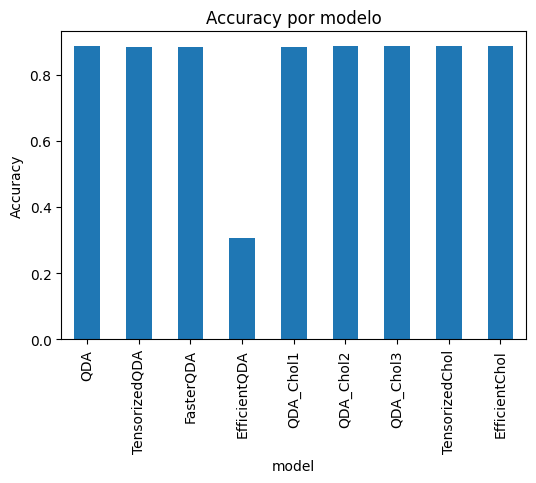

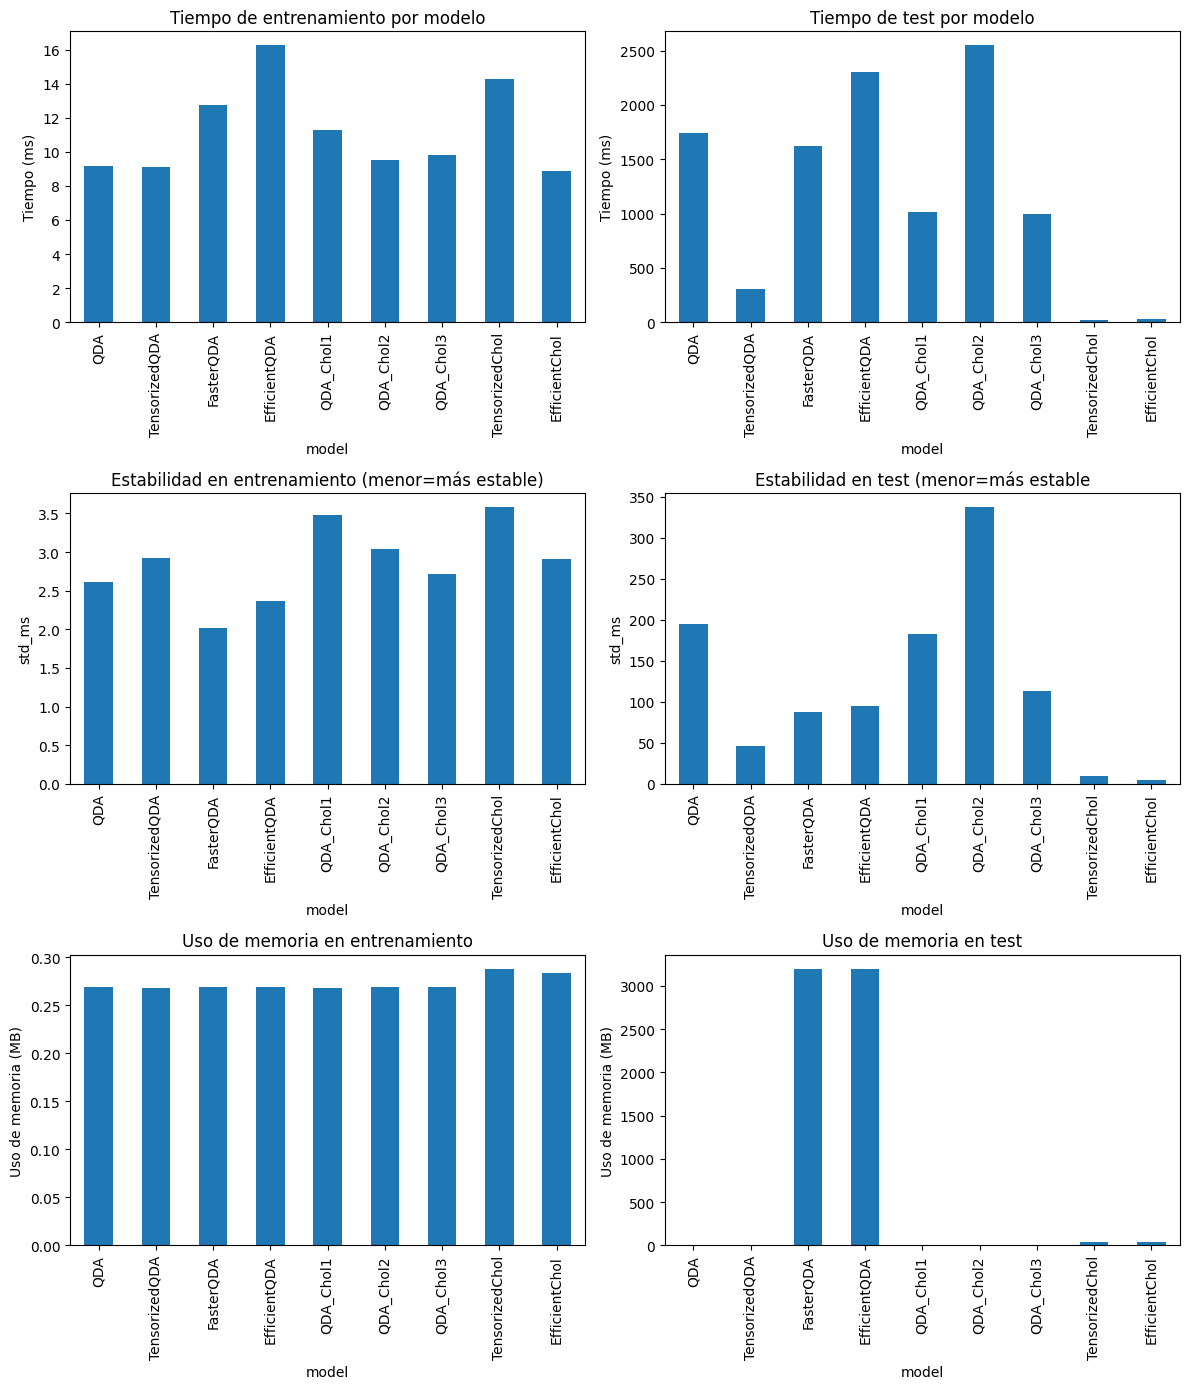

In [41]:
import matplotlib.pyplot as plt

# Comparamos el accuracy de los modelos 
summ["mean_accuracy"].plot.bar(figsize=(6, 4))
plt.ylabel("Accuracy")
plt.title("Accuracy por modelo") 
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(12, 14))
axes = axes.flatten()

# Comparamos los tiempos de entrenamiento de los modelos
summ["train_median_ms"].plot.bar(ax=axes[0])
axes[0].set_ylabel("Tiempo (ms)")
axes[0].set_title("Tiempo de entrenamiento por modelo")

# Comparamos los tiempos de test de los modelos
summ["test_median_ms"].plot.bar(ax=axes[1])
axes[1].set_ylabel("Tiempo (ms)")
axes[1].set_title("Tiempo de test por modelo")

# Comparamos la estabilidad de entrenamiento de los modelos, expresada como desvío estandar del tiempo
summ["train_std_ms"].plot.bar(ax=axes[2])
axes[2].set_ylabel("std_ms")
axes[2].set_title("Estabilidad en entrenamiento (menor=más estable)")

# Comparamos la estabilidad de test de los modelos, expresada como desvío estandar del tiempo
summ["test_std_ms"].plot.bar(ax=axes[3])
axes[3].set_ylabel("std_ms")
axes[3].set_title("Estabilidad en test (menor=más estable")

# Comparamos el uso de memoria en entrenamiento de los modelos
summ["train_mem_median_mb"].plot.bar(ax=axes[4])
axes[4].set_ylabel("Uso de memoria (MB)")
axes[4].set_title("Uso de memoria en entrenamiento")
    
# Comparamos el uso de memoria en test de los modelos
summ["test_mem_median_mb"].plot.bar(ax=axes[5])
axes[5].set_ylabel("Uso de memoria (MB)")
axes[5].set_title("Uso de memoria en test")
    
plt.tight_layout()
plt.show()

Estas conclusiones surgen de haber probado los modelos con el dataset de Letters, el más exigente (1600 rows de train y 4000 rows de test). Para la evaluación de la estabilidad de los modelos recurrimos al desvío estándar y no al coeficiente de variación porque este último indicador favorece a los modelos más lentos.

a) Los niveles de **accuracy** son similares en todos los modelos, con una diferencia de 0.01% entre el de mayor y el de menor accuracy. Esto está en línea con lo esperado porque los modelos realizan operaciones matemáticas equivalentes

b) El **tiempo de entrenamiento** esta en el rango de 8 a 24 ms. El modelo con mejor tiempo de entrenamiento es TensorizedQDA. Los modelos FasterQDA y TensorizedQDA son los más lentos en el entrenamiento, con tiempos que más que duplican los de QDA. Los tiempos de entrenamiento de EfficientQDA y EfficientChol son 20% mayores que los de QDA. En términos de **estabilidad en el entrenamiento**, el mejor es TensorizedQDA y FasterQDA es marcadamente el peor.

c) El **tiempo de test** está en el rango de 20 ms a casi 3000 ms. Los modelos más rápidos son EfficientChol, TensorizedChol y EfficientQDA. Son también los más estables en test. EfficientChol es 100x más rápido que QDA. Los modelos más lentos QDAChol2, FasterQDA y QDA, que tienden a ser también más inestables.

d) El **uso de memoria en train** es muy similar en todos los modelos, en el rango de 0.268 Mb a 0.288 Mb, TensorizedChol y EfficientChol consumen aprox. 5% mas memora que QDA.

e) El **uso de memoria en test** tiene en FasterQDA un claro outlier con un consumo de memoria que supera los 3Gb. Los modelos EfficientQDA, TensorizedQDA y EfficientChol consumen aprox. 39 Mb, mientras que QDA y QDA_Chol1 a 3 tienen un consumo de aprox. 0.1 Mb.

f) **QDA** itera por observación y por clase, por lo que es esperable que sea lento y consuma poca memoria **(coincide con lo esperado)**

g) **TensorizedQDA** tensoriza las clases y no las observaciones, ganando en velocidad (en más rápido en train) manteniendo un bajo consumo de memoria **(coincide con lo esperado)**

h) **FasterQDA** tiene en conjunto el peor desempeño. Esto se debe a que en `m = np.transpose(unbiased, (0, 2, 1)) @ self.tensor_inv_cov @ unbiased` m tiene dimensionalidad **(k, n, n)** **(coincide con lo esperado)**

i) **EfficientQDA** elude la matriz de diemensionalidad (k, n, n) de la FasterQDA por lo que tanto el tiempo de test como el uso de memoria caen drásticamente **(coincide con lo esperado)**

j) **QDAChol1** simplifica el cálculo de la matriz de covarianza por lo cual la mejora de tiempos de test vs QDA coinciden con lo esperado, sin embargo debería ocurrir algo similar con los tiempos de train y eso no sucede **(coincidencia parcial con lo esperado)**

k) **QDAChol2** es en concepto computacionalmente más eficiente que QDAChol1 debido a que evita el cálculo de la inversa de Cholesky, pero su tiempo de test y su uso de memoria son peores que los de QDAChol1 **(no coincide con lo esperado)**

l) **QDAChol3** deberia tener mejores tiempos de train que QDAChol1 por usar una mejor función para calcular la matriz triangular L, pero los tiempos en ambos modelos son similares y QDAChol3 es más inestable **(no coincide con lo esperado)**

m) **TensorizedChol** tiene un tiempo de test de los más bajos y un tiempo de train de los más altos, lo que resulta contraintuitivo. Puede deberse a que procesa clases y observaciones en una única pasada, recargando la necesidad de cálculo **(coincidencia parcial con lo esperado)**

n) **EfficientChol** combina EfficentQDA con TensorizedChol por lo que mejora los indicadores de ambos modelos **(coincide con lo esperado)**

Completados: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14

### Maximiliano Christener: 5 - 10
### Luiz Diaz: 6 - 11
### Mariano Fagre: 7 - 12
### Juan Pablo Skobalski: 4 - 8 - 13
### Ronald Uthurralt: 9 - 14
